# Preprocess_MIMIC.ipynb

This notebook preprocesses the Staph Aureus Coag+ dataset, including additional column removal and discretization of the data. We also split the data for E3.The datasets are then saved as CSV files.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [94]:
df = pd.read_csv("inter_query_7.csv")

In [95]:
remove_columns = ["event_id", "subject_id", "hadm_id", "date", "drugs"]
df.drop(columns=remove_columns, inplace=True)
df.head()

,ab_name,spec_type_desc,interpretation,gender,age,admission_type,admission_location,admission_days,exitus,discharge_location,icu_when_culture,days_since_last_treatment,number_of_treatments_last_180_days,days_with_treatment_last_180_days
0,PENICILLIN,SPUTUM,R,M,56,ELECTIVE,PHYS REFERRAL/NORMAL DELI,4,f,DISC-TRAN TO FEDERAL HC,SICU,360,0,0
1,ERYTHROMYCIN,SPUTUM,R,M,62,EMERGENCY,EMERGENCY ROOM ADMIT,4,f,SNF,MICU,360,0,0
2,RIFAMPIN,SPUTUM,S,M,62,EMERGENCY,EMERGENCY ROOM ADMIT,4,f,SNF,MICU,360,0,0
3,TETRACYCLINE,SPUTUM,S,M,62,EMERGENCY,EMERGENCY ROOM ADMIT,11,f,SNF,MICU,360,0,0
4,LEVOFLOXACIN,BRONCHOALVEOLAR LAVAGE,R,M,80,EMERGENCY,EMERGENCY ROOM ADMIT,0,f,LONG TERM CARE HOSPITAL,MICU,360,0,0


In [96]:
def rename_categories(cat_series):
    size = len(cat_series.cat.categories)
    new_names = [ "I"+str(i) for i in range(size)]
    return cat_series.cat.rename_categories(new_names)

In [97]:
df["admission_days"] = pd.qcut(df["admission_days"],4,duplicates="drop")
df["admission_days"] = rename_categories(df["admission_days"])
df["age"] = pd.qcut(df["age"],4,duplicates="drop")
df["age"] = rename_categories(df["age"])

In [98]:
# In the SQL query, we only check for treatments in the last 180 days. If no treatment was found, we set the days since last treatment to 360.
# We swap that value for NAN here
df.loc[df["days_since_last_treatment"] == 360,"days_since_last_treatment"] = np.NaN
df["days_since_last_treatment"] = pd.qcut(df["days_since_last_treatment"],4,duplicates="drop")
df["days_since_last_treatment"] = rename_categories(df["days_since_last_treatment"])

Since most patients have no prior treatment, which will oversimplify the binning by cuartiles, we group this values in a different bin.

<Axes: >

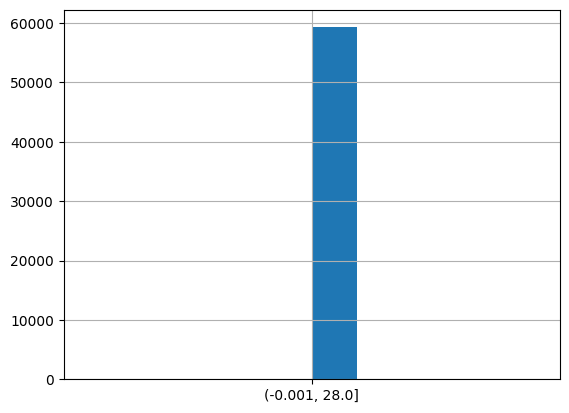

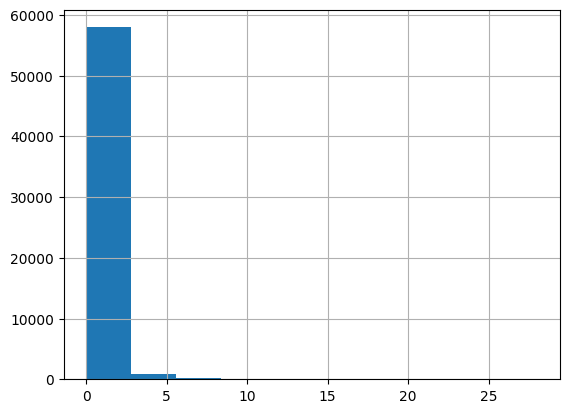

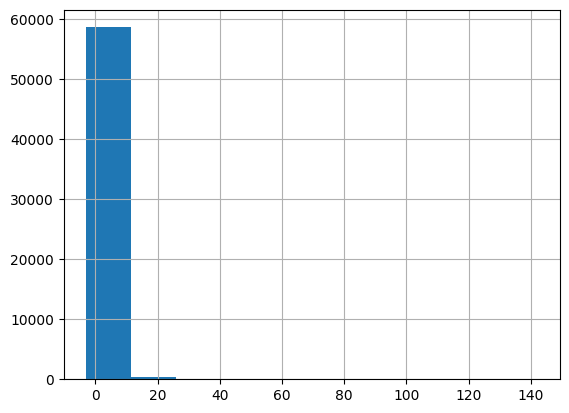

In [99]:
# pd.qcut(df.admission_days, 4)
pd.qcut(df["number_of_treatments_last_180_days"], 4, duplicates="drop").astype("str").hist()
plt.figure()
df["number_of_treatments_last_180_days"].hist()
plt.figure()
df["days_with_treatment_last_180_days"].hist()

In [100]:
df.loc[df["number_of_treatments_last_180_days"] == 0,"number_of_treatments_last_180_days"] = np.NaN
# df.loc[:,"number_of_treatments_last_180_days"] = pd.qcut(df["number_of_treatments_last_180_days"], 4, duplicates="drop").cat.rename_categories(["I0","I1","I2","I3"]).astype("str")
df.loc[:,"number_of_treatments_last_180_days"] = pd.qcut(df["number_of_treatments_last_180_days"], 4, duplicates="drop")
df["number_of_treatments_last_180_days"] = rename_categories(df["number_of_treatments_last_180_days"]).astype("str")
df.loc[df["number_of_treatments_last_180_days"] == "nan", "number_of_treatments_last_180_days"] = "0"

/tmp/ipykernel_65611/4055736834.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[NaN, NaN, NaN, NaN, NaN, ..., NaN, NaN, NaN, NaN, NaN]
Length: 59274
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 3.0] < (3.0, 28.0]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,"number_of_treatments_last_180_days"] = pd.qcut(df["number_of_treatments_last_180_days"], 4, duplicates="drop")


In [101]:

df.loc[df["days_with_treatment_last_180_days"] == 0,"days_with_treatment_last_180_days"] = np.NaN
df.loc[:,"days_with_treatment_last_180_days"] = pd.qcut(df["days_with_treatment_last_180_days"], 4, duplicates="drop")
df["days_with_treatment_last_180_days"] = rename_categories(df["days_with_treatment_last_180_days"]).astype("str")
df.loc[df["days_with_treatment_last_180_days"] == "nan", "days_with_treatment_last_180_days"] = "0"

/tmp/ipykernel_65611/2024723783.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[NaN, NaN, NaN, NaN, NaN, ..., NaN, NaN, NaN, NaN, NaN]
Length: 59274
Categories (4, interval[float64, right]): [(-3.001, 2.0] < (2.0, 4.0] < (4.0, 9.0] < (9.0, 142.0]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,"days_with_treatment_last_180_days"] = pd.qcut(df["days_with_treatment_last_180_days"], 4, duplicates="drop")


In [102]:
df.number_of_treatments_last_180_days.value_counts()

number_of_treatments_last_180_days
0     54908
I0     3043
I2      847
I1      476
Name: count, dtype: int64

In [103]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["interpretation"], random_state=42)

In [104]:
df.to_csv("sa-cog-pos.csv", index = False)
df_train.to_csv("sa-cog-pos_train.csv", index = False)
df_test.to_csv("sa-cog-pos_test.csv", index = False)